# Homework week 6

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Q1

Conduct a prior predictive simulation for the Reedfrog model. By this I mean to
simulate the prior distribution of tank survival probabilities $\alpha_j$. Start by using this
prior:

$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1) $$
$$ \sigma \sim \text{Exp}(1) $$

Be sure to transform the $\alpha_j$ values to the probability scale for plotting and summary.
How does increasing the width of the prior on σ change the prior distribution of $\alpha_j$?
You might try Exponential(10) and Exponential(0.1) for example.

## Answer

We can setup the model in `pymc` and let the machinery take care of things.

In [5]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_frogs = pd.read_csv(DATA_DIR + "reedfrogs.csv", sep=";", header=0)
df_frogs.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


<IPython.core.display.Javascript object>

In [277]:
prior_pred_dict = dict()
exp_values = [0.1, 1, 10]
tank = df_frogs.index

for exp_value in exp_values:

    with pm.Model() as mq1a:

        # define priors
        a_bar = pm.Normal("a_bar", mu=0, sd=1)
        sigma = pm.Exponential("sigma", exp_value)

        # adaptive prior
        a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

        # link function
        p = pm.Deterministic("p", pm.math.invlogit(a_j[tank]))

        # likelihood
        # s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

        # generate prior predictive samples
        prior_pred = pm.sample_prior_predictive(1000, var_names='p')

        # store prior predictive samples
        prior_pred_dict[exp_value] = prior_pred['p']
    

<IPython.core.display.Javascript object>

In [299]:
prior_pred_dict = dict()
exp_values = [0.1, 1, 10]
# tank = df_frogs.index

for exp_value in exp_values:

    with pm.Model() as mq1a:

        # define priors
        a_bar = pm.Normal("a_bar", mu=0, sd=1)
        sigma = pm.Exponential("sigma", exp_value)

        # adaptive prior
        a_j = pm.Normal("a_j", a_bar, sigma)

        # link function
        p = pm.Deterministic("p", pm.math.invlogit(a_j))

        # likelihood (not needed)
        # s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

        # generate prior predictive samples
        prior_pred = pm.sample_prior_predictive(1000, var_names=['a_j', 'p'])

        # store prior predictive samples
        prior_pred_dict[exp_value] = prior_pred
    

<IPython.core.display.Javascript object>

In [292]:
# az.summary(prior_pred_dict)

<IPython.core.display.Javascript object>

In [ ]:
# # adaptive prior
#     a_bar = pm.Normal("a_bar", 0.0, 1.5)

#     # prior for SD of tanks
#     sigma = pm.Exponential("sigma", 1.0)

#     # adaptive prior
#     a = pm.Normal("a", a_bar, sigma, shape=n_tanks)

#     p = pm.math.invlogit(a[tank])

#     S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

0.1 [0.9995417 0.9995417] 

1 [0.69089448 0.69089448] 

10 [0.45467512 0.45467512] 



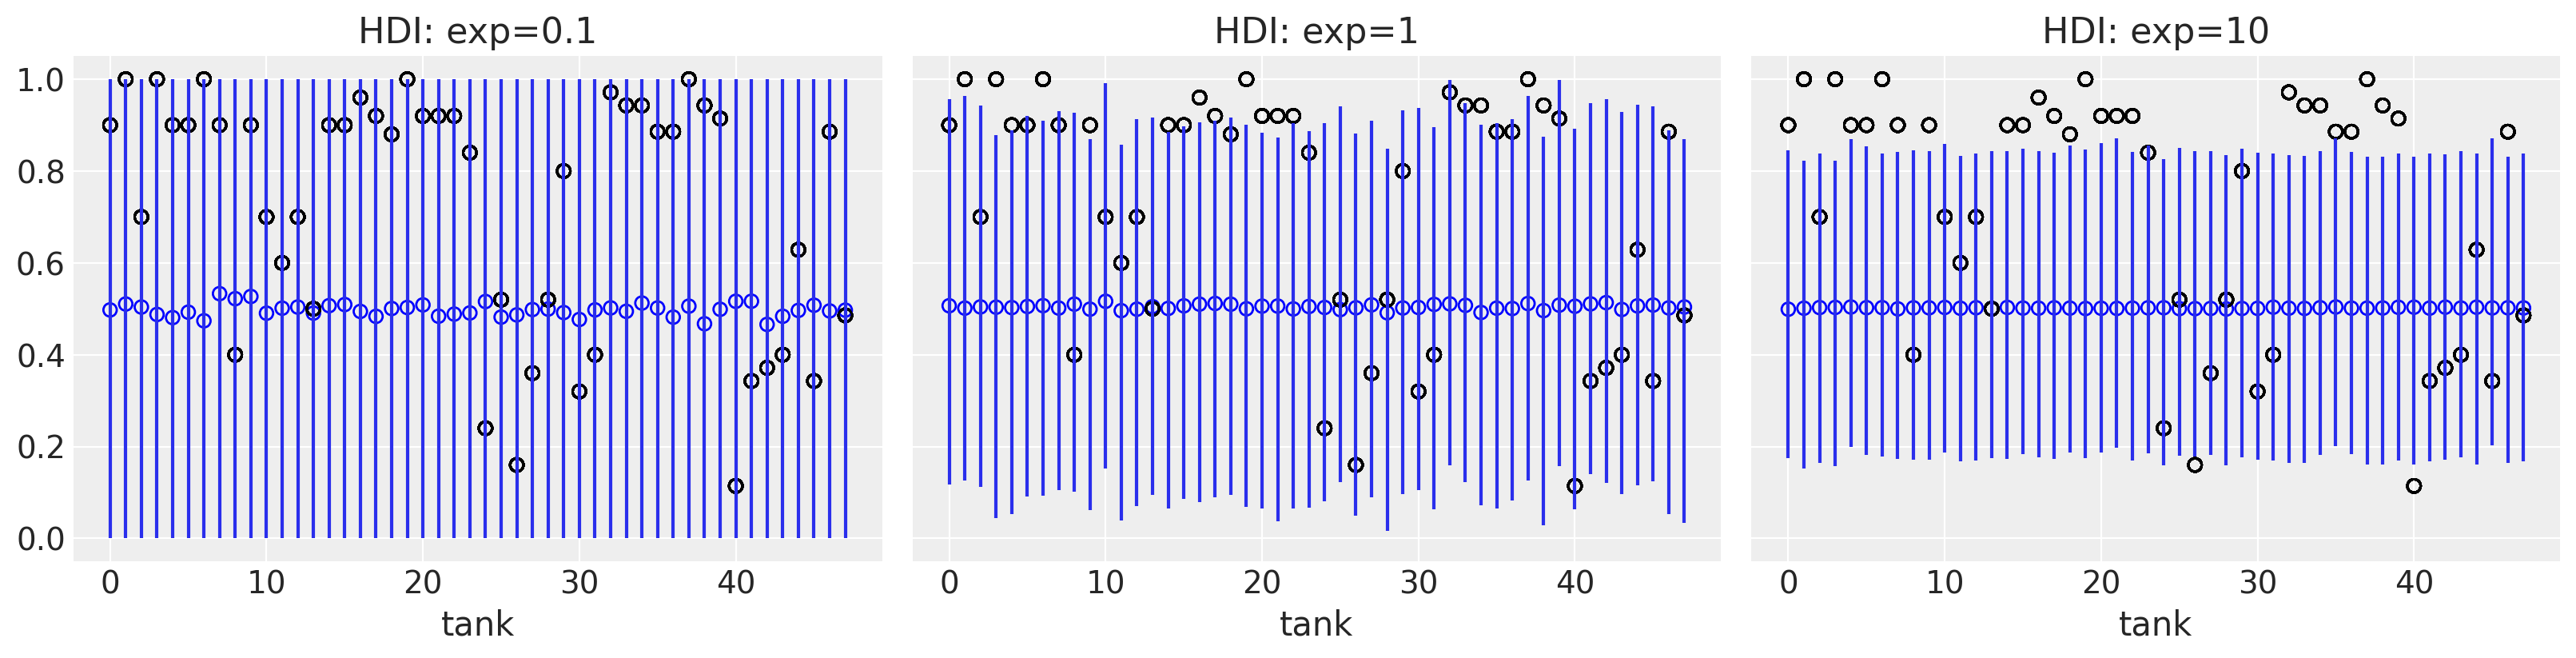

<IPython.core.display.Javascript object>

In [278]:
f, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)

for exp, ax in zip(exp_values, axs.flat):
    prior_pred = prior_pred_dict[exp]
    
    for i in range(len(df_frogs)):
        # HDI of prior predictive
        ax.vlines(i, ymin=az.hdi(prior_pred[:, i])[0], ymax=az.hdi(prior_pred[:, i])[1])

        # mean of prior predictive
        ax.scatter(df_frogs.index[i], prior_pred[:, i].mean(), facecolors='none', edgecolors='blue')
        # data
        ax.scatter(df_frogs.index, df_frogs["propsurv"], facecolors='none', edgecolors='k')
        ax.set(xlabel='tank', title=f'HDI: exp={exp}')

    print(exp, np.percentile(prior_pred[0, i], [5.5, 94.5]), '\n')

In [ ]:
exp_values = [0.1, 1, 10]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
for exp in exp_values:
    abar = stats.norm.rvs(0, 1.5, size=10**5)
    s = stats.expon.rvs(exp, size=10**5)
    a = stats.norm.rvs(abar, s, size=10**5)
    sns.kdeplot(a, ax=ax1, label=f'{exp}')
    # az.plot_density(a, ax=ax1, backend_kwargs={'label':f'{exp}'})
    sns.kdeplot(expit(a), ax=ax2, label=f'{exp}')

    print(f"89% interval for {exp}: ", np.percentile(expit(a), [5.5, 89.5]), "\n")

ax1.legend(title='Exp parameter for sigma')
ax1.set(xlabel='alpha (Z values)', ylabel='density') #, xlim=[-10, 10])

ax2.legend(title='Exp parameter for sigma')
ax2.set(xlabel='probability', ylabel='density')

[Text(0.5, 0, 'probability'), Text(0, 0.5, 'density')]

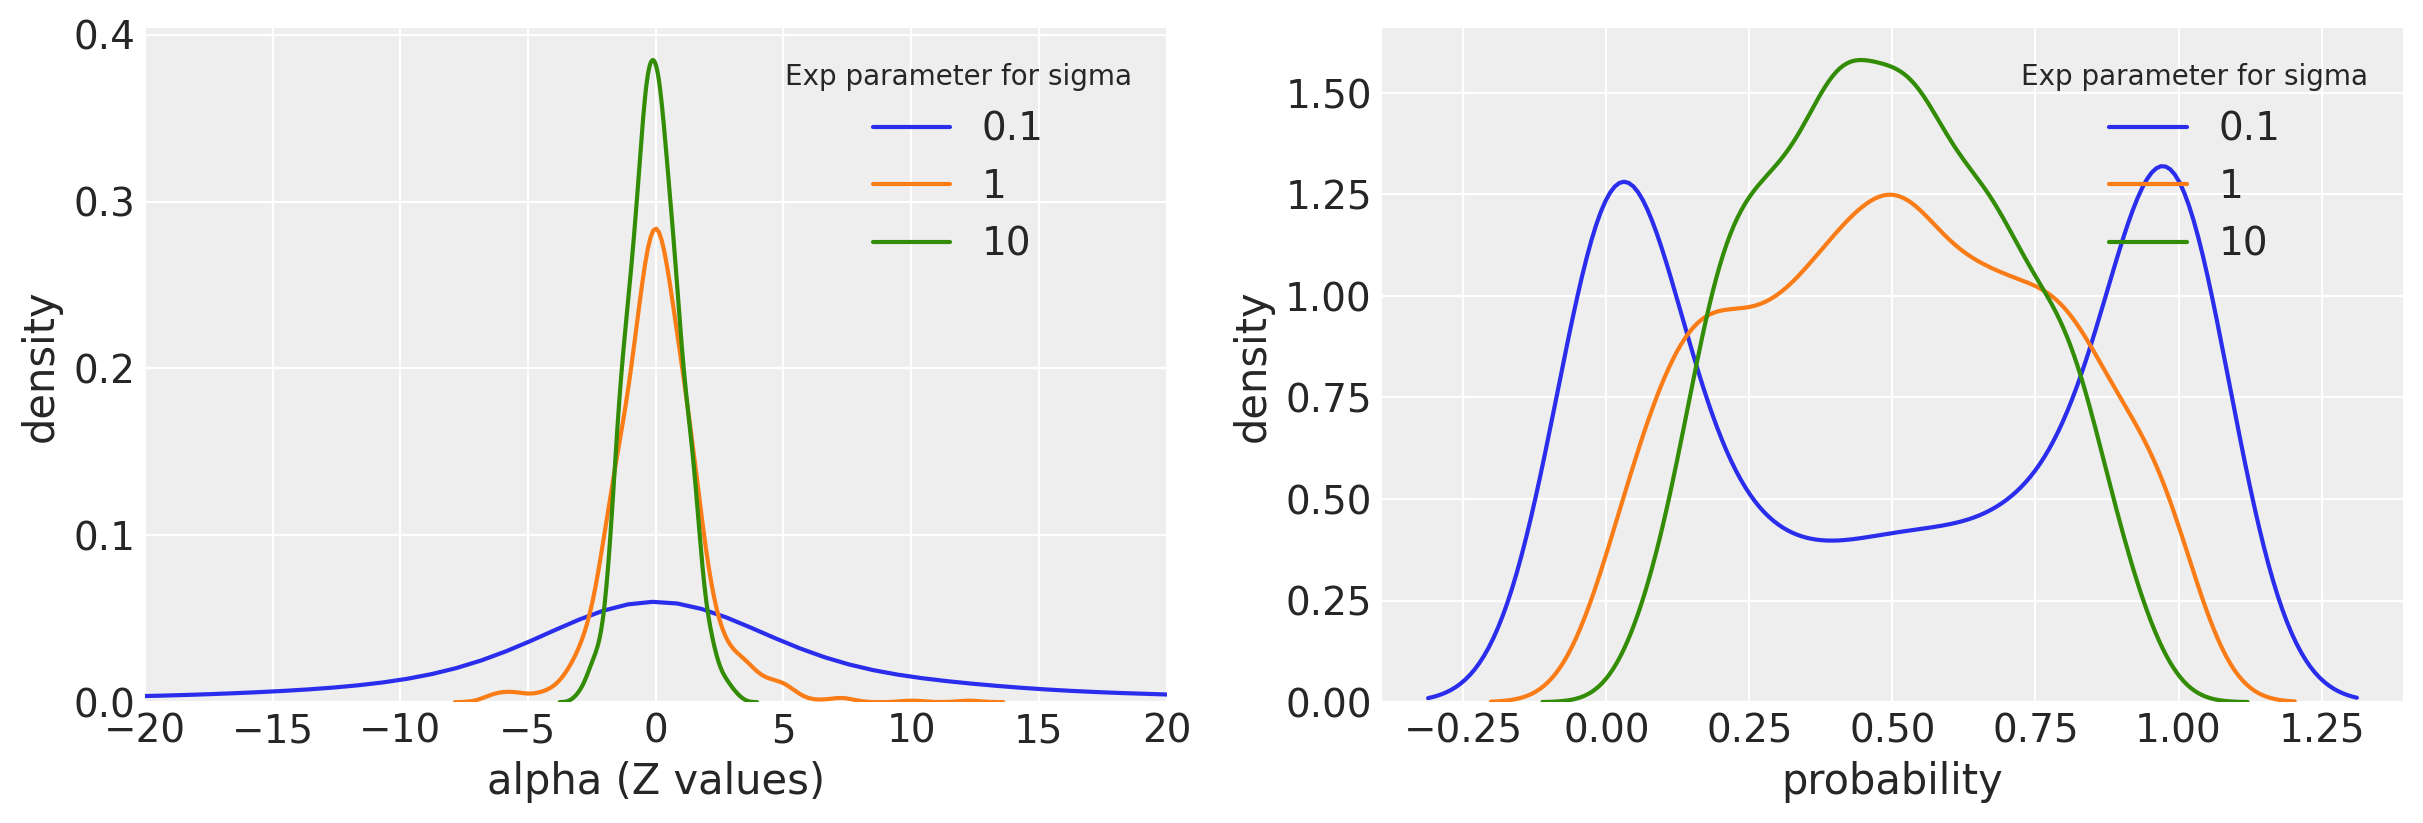

<IPython.core.display.Javascript object>

In [298]:
exp_values = [0.1, 1, 10]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
for exp in exp_values:
    prior_pred_a = prior_pred_dict[exp]['a_j']
    prior_pred_p = prior_pred_dict[exp]['p']
    

    sns.kdeplot(prior_pred_a, ax=ax1, label=f'{exp}')
    # az.plot_density(a, ax=ax1, backend_kwargs={'label':f'{exp}'})
    sns.kdeplot(expit(prior_pred_a), ax=ax2, label=f'{exp}')

    # print(f"89% interval for {exp}: ", np.percentile(expit(a), [5.5, 89.5]), "\n")

ax1.legend(title='Exp parameter for sigma')
ax1.set(xlabel='alpha (Z values)', ylabel='density', xlim=[-20, 20])

ax2.legend(title='Exp parameter for sigma')
ax2.set(xlabel='probability', ylabel='density')

Why does it look like this? It will be explained down below.

### Scipy.stats way

R code
```
abar <- rnorm(1e5,0,1.5)
s <- rexp(1e5,10)
a <- rnorm(1e5,abar,s)
dens( a , xlim=c(-6,6) , lwd=4 , col=2 , xlab="a_j" , ylab="Density" , adj=1 )
dens( logistic(a) , xlim=c(-0.2,1.2) , lwd=4 , col=2 , xlab="a_j" , ylab="Density" , adj=1 )
```

Note that the [the scipy.stats documentation for the exponential distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html) about parameterizing:

> A common parameterization for expon is in terms of the rate parameter lambda, such that pdf = lambda * exp(-lambda * x). This parameterization corresponds to using scale = 1 / lambda.

See [this notebook](https://github.com/benslack19/stats_rethinking/blob/main/SR_notebooks_2022/stats_rethinking_hw06_check.ipynb) for more details and comparisons between the R and Python code.

In [82]:
from scipy.special import expit

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'probability'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'Distribution of p')]

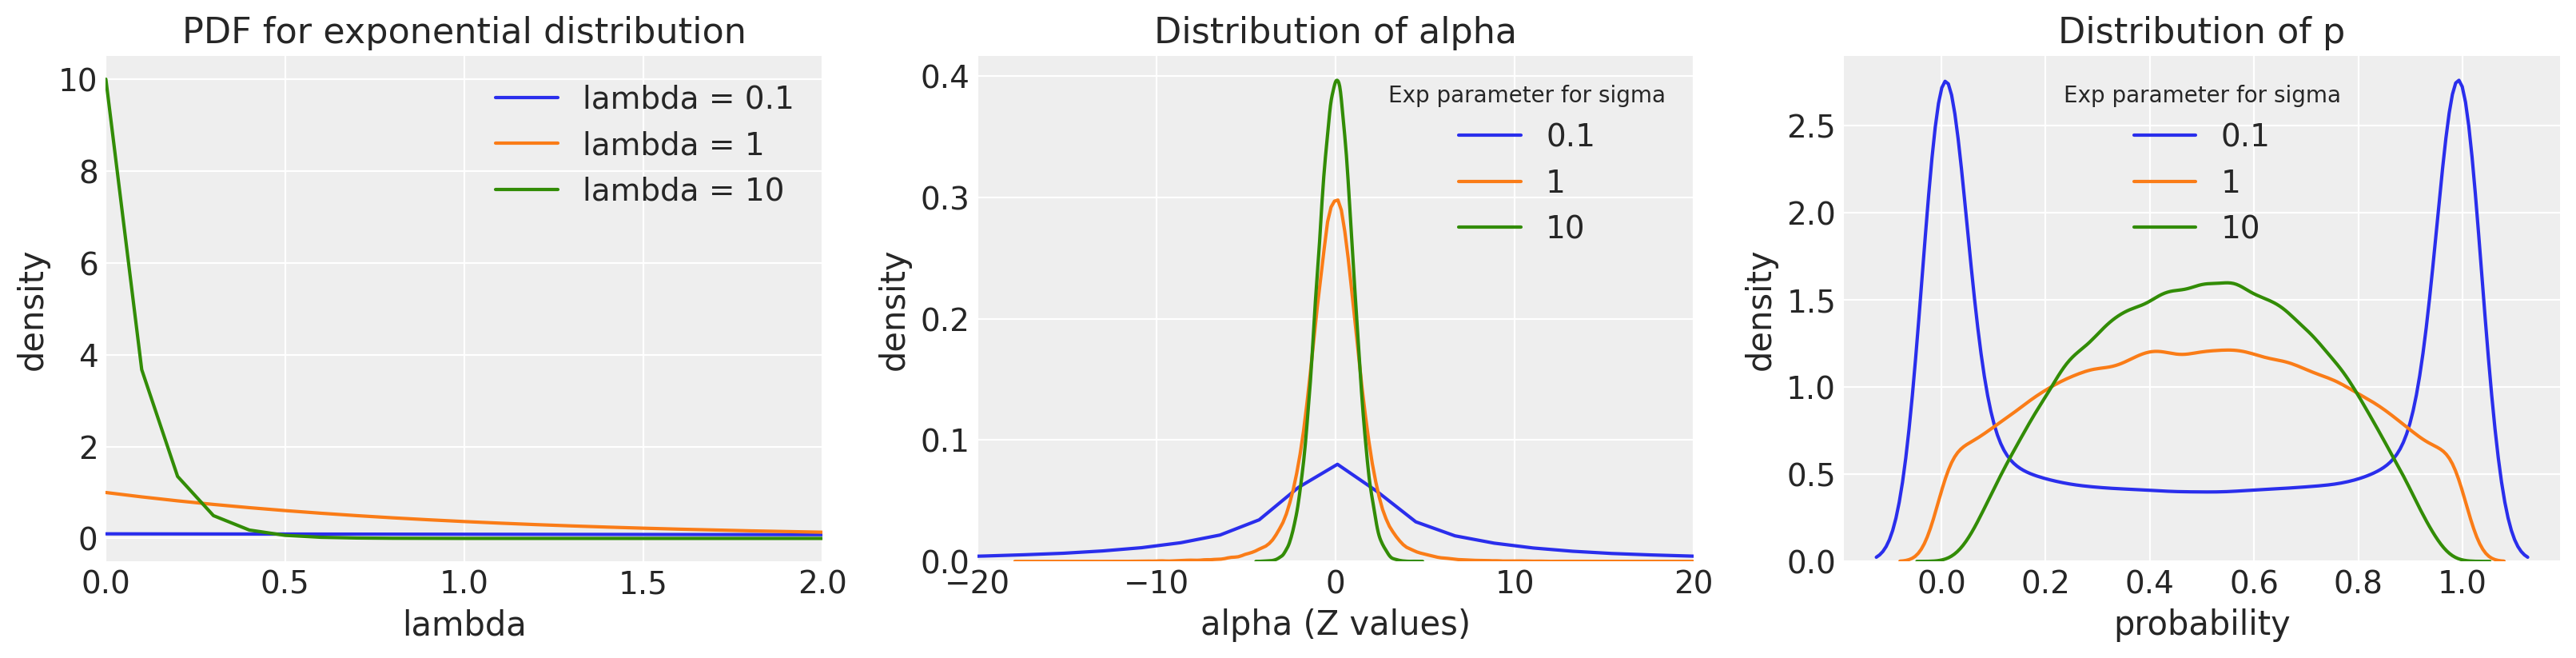

<IPython.core.display.Javascript object>

In [324]:
lambda_values = [0.1, 1, 10]

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,4))

for lamb in lambda_values:
    abar = stats.norm.rvs(0, 1, size=10**5)
    s = stats.expon.rvs(scale = 1/lamb, size=10**5)
    a = stats.norm.rvs(abar, s, size=10**5)

    # Plot distribution of lambda value
    x = np.linspace(0, 100, 1000)
    y = stats.expon.pdf(x, scale=1/lamb)
    ax0.plot(x, y, label=f"lambda = {lamb}")
    
    # Distribution of alpha
    sns.kdeplot(a, ax=ax1, label=f'{lamb}')

    # Distribution of p
    sns.kdeplot(expit(a), ax=ax2, label=f'{lamb}')

ax0.legend()
ax0.set(xlim=[0, 2], xlabel='lambda', ylabel='density', title='PDF for exponential distribution')

ax1.legend(title='Exp parameter for sigma')
ax1.set(xlabel='alpha (Z values)', ylabel='density', xlim=[-20, 20], title='Distribution of alpha')

ax2.legend(title='Exp parameter for sigma')
ax2.set(xlabel='probability', ylabel='density', title='Distribution of p')

A flat prior makes cases of 0 and 1 allows extreme values (outside of Z values of -6 or +6) to be more possible.

A lower lamda value for exponential leads to wider Gaussian distribution for alpha, leading to the bimodal distribution in p.

# Q2

Revisit the `Reedfrog` survival data, `data(reedfrogs)`. Start with the varying
effects model from the book and lecture. Then modify it to estimate the causal effects
of the treatment variables `pred` and `size`, including how `size` might modify the effect
of predation. An easy approach is to estimate an effect for each combination of `pred`
and `size`. Justify your model with a DAG of this experiment.

## Answer

As suggested, we'll run different models. Here's how I'll name them:
- `m2a`: model from the book and lecture
- `m2b`: adding `pred` only to `m2a`
- `m2c`: adding `size` only to `m2a`
- `m2d`: adding `pred` and `size` to `m2a` as additive terms
- `m2e`: adding `pred` and `size` to `m2a` as interactive terms

In [122]:
df_frogs.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


<IPython.core.display.Javascript object>

In [123]:
df_frogs['pred'].value_counts()

no      24
pred    24
Name: pred, dtype: int64

<IPython.core.display.Javascript object>

In [124]:
df_frogs['size'].value_counts()

big      24
small    24
Name: size, dtype: int64

<IPython.core.display.Javascript object>

In [133]:
# encode categorical variables
df_frogs['pred_code'] = pd.Categorical(df_frogs['pred'], categories=['no', 'pred']).codes
df_frogs['size_code'] = pd.Categorical(df_frogs['size'], categories=['small', 'big']).codes

<IPython.core.display.Javascript object>

In [134]:
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code
0,10,no,big,9,0.9,0,1
1,10,no,big,10,1.0,0,1
2,10,no,big,7,0.7,0,1
3,10,no,big,10,1.0,0,1
4,10,no,small,9,0.9,0,0


<IPython.core.display.Javascript object>

### Model m2a, varying effects only

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


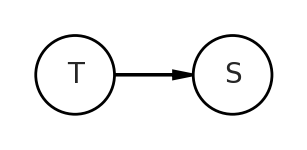

<IPython.core.display.Javascript object>

In [136]:
dag = CausalGraphicalModel(
    nodes=["T", "S"],
    edges=[
        ("T", "S"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "T": (0, 1),
    "S": (1, 1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [98]:
with pm.Model() as mq2a:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 0.1)

    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank]))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq2a = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [100]:
az.summary(trace_mq2a)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.296,0.251,0.863,1.667,0.003,0.002,5996.0,5992.0,5997.0,3251.0,1.0
a_j[0],2.115,0.866,0.768,3.427,0.010,0.009,7130.0,4957.0,7622.0,2984.0,1.0
a_j[1],3.073,1.131,1.246,4.732,0.015,0.013,5493.0,3677.0,6706.0,2516.0,1.0
a_j[2],0.983,0.673,-0.122,2.012,0.007,0.007,8828.0,4541.0,9161.0,3125.0,1.0
a_j[3],3.069,1.137,1.274,4.796,0.015,0.012,6078.0,4358.0,7009.0,3077.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[43],0.418,0.079,0.295,0.543,0.001,0.001,8561.0,8561.0,8562.0,2633.0,1.0
p[44],0.638,0.077,0.519,0.764,0.001,0.001,7061.0,6898.0,6956.0,3114.0,1.0
p[45],0.363,0.077,0.240,0.485,0.001,0.001,8342.0,7618.0,8298.0,2872.0,1.0
p[46],0.877,0.051,0.803,0.959,0.001,0.000,8688.0,8688.0,8627.0,2955.0,1.0


<IPython.core.display.Javascript object>

In [111]:
az.summary(trace_mq2a, var_names=['a_bar', 'sigma'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.296,0.251,0.863,1.667,0.003,0.002,5996.0,5992.0,5997.0,3251.0,1.0
sigma,1.648,0.224,1.301,1.995,0.004,0.003,2822.0,2822.0,2774.0,2860.0,1.0


<IPython.core.display.Javascript object>

It's interesting that the posterior for `sigma` is 1.65, more than an order of magnitude more than the prior. It also means that we can expect some tanks to have their distributions where most may survive and others where most will die.

In [99]:
trace_mq2a_df = pm.trace_to_dataframe(trace_mq2a)
trace_mq2a_df.head()

,a_bar,a_j__0,a_j__1,a_j__2,a_j__3,a_j__4,a_j__5,a_j__6,a_j__7,a_j__8,...,p__38,p__39,p__40,p__41,p__42,p__43,p__44,p__45,p__46,p__47
0,1.240397,1.848262,1.580416,0.707314,3.194724,1.614119,1.840206,3.973333,2.539600,0.545346,...,0.954540,0.877692,0.094630,0.451843,0.269722,0.297850,0.565764,0.407592,0.786930,0.526400
1,1.492661,2.926718,4.277343,1.490747,2.371999,2.243963,4.589038,2.271700,1.543278,-0.859360,...,0.898543,0.924764,0.157648,0.277053,0.511923,0.541927,0.699496,0.308257,0.945072,0.484013
2,1.416736,1.991002,1.556597,1.492597,3.232768,1.913302,2.196354,3.875496,2.317014,0.498267,...,0.958566,0.958838,0.131510,0.518956,0.266873,0.336155,0.579801,0.394759,0.942264,0.477074
3,1.257386,2.573997,4.374416,0.392875,3.048121,1.986203,1.866655,2.566740,1.727124,-0.722786,...,0.910605,0.815644,0.172924,0.226718,0.531400,0.510472,0.699022,0.333935,0.922753,0.521260
4,1.640775,2.629832,3.721734,0.874680,2.820660,2.224548,1.003232,4.476537,2.127149,-0.039570,...,0.939886,0.910951,0.107037,0.363650,0.423653,0.474772,0.668397,0.420610,0.919409,0.364808


<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'Posterior predictive'),
 Text(0.5, 0, 'probability'),
 Text(0, 0.5, 'density')]

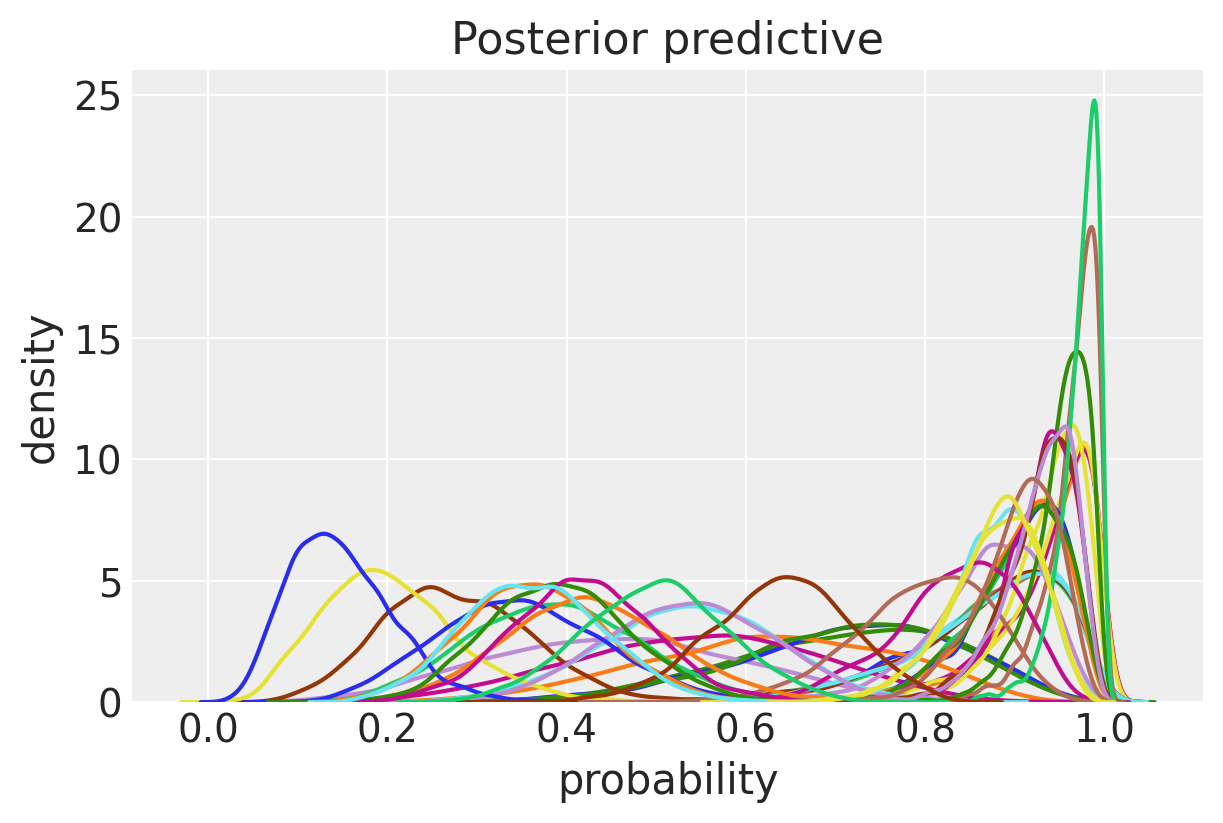

<IPython.core.display.Javascript object>

In [120]:
f, ax1 = plt.subplots(figsize=(6, 4))
for i in range(48):
    sns.kdeplot(expit(trace_mq2a_df[f'a_j__{i}']), ax=ax1)
ax1.set(title='Posterior predictive', xlabel='probability', ylabel='density')

### Model m2b, varying effects with pred

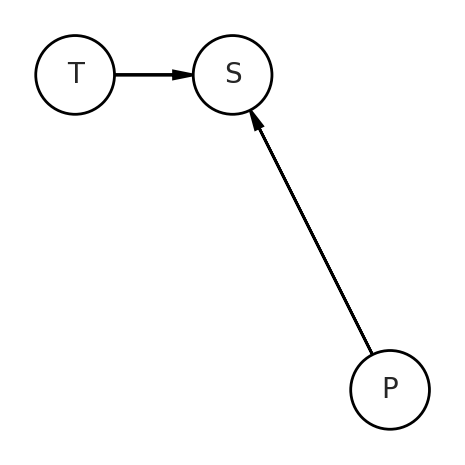

<IPython.core.display.Javascript object>

In [137]:
# model m2b with pred

dag = CausalGraphicalModel(
    nodes=["T", "S", "P"],
    edges=[
        ("T", "S"),
        ("P", "S"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "T": (0, 1),
    "S": (1, 1),
    "P": (2, -1)
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [140]:
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code
0,10,no,big,9,0.9,0,1
1,10,no,big,10,1.0,0,1
2,10,no,big,7,0.7,0,1
3,10,no,big,10,1.0,0,1
4,10,no,small,9,0.9,0,0


<IPython.core.display.Javascript object>

In [143]:
with pm.Model() as mq2b:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bP = pm.Normal("bP", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 0.1)
    

    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bP*df_frogs['pred_code']))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq2b = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bP, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bP, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [147]:
trace_mq2b_df = pm.trace_to_dataframe(trace_mq2b)
trace_mq2b_df.head()

,a_bar,bP,a_j__0,a_j__1,a_j__2,a_j__3,a_j__4,a_j__5,a_j__6,a_j__7,...,p__38,p__39,p__40,p__41,p__42,p__43,p__44,p__45,p__46,p__47
0,2.535217,-2.556544,3.056563,2.565598,2.284718,2.534679,2.335616,1.460109,3.860417,2.888651,...,0.933142,0.874559,0.072710,0.254193,0.396187,0.371242,0.657963,0.288252,0.803705,0.627290
1,2.653467,-2.613959,1.419520,3.190847,1.060973,4.041411,2.177209,1.711217,2.624908,2.020362,...,0.882945,0.939836,0.233763,0.380472,0.346898,0.474671,0.676058,0.448401,0.879475,0.377682
2,2.648765,-2.548283,2.980238,2.449005,1.998845,2.025359,3.479801,2.709464,2.599941,2.351583,...,0.970163,0.869245,0.211600,0.356397,0.379912,0.520704,0.658782,0.327413,0.669036,0.583010
3,2.714456,-2.225339,2.369472,2.888498,1.542000,3.146265,1.813766,2.001647,2.914320,3.108024,...,0.843110,0.918370,0.196145,0.421518,0.500700,0.366326,0.572133,0.472609,0.857458,0.488586
4,2.388007,-2.372876,2.631702,2.908757,1.684049,2.648396,1.858671,1.933308,3.235229,3.201907,...,0.837912,0.922627,0.185406,0.405377,0.380464,0.385445,0.488707,0.476888,0.834189,0.534567


<IPython.core.display.Javascript object>

### Model m2c, varying effects with size

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


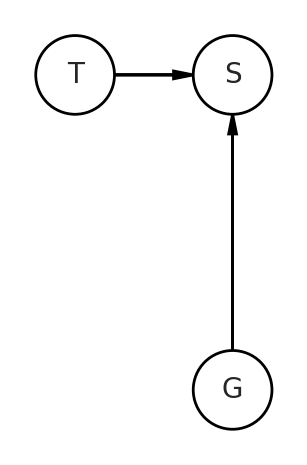

<IPython.core.display.Javascript object>

In [159]:
# model m2c with size

dag = CausalGraphicalModel(
    nodes=["T", "S", "G"],
    edges=[
        ("T", "S"),
        ("G", "S"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "T": (0, 1),
    "S": (1, 1),
    "G": (1, -1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [160]:
with pm.Model() as mq2c:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bG = pm.Normal("bG", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 0.1)
    
    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bG*df_frogs['size_code']))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq2c = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bG, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bG, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [ ]:
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code
0,10,no,big,9,0.9,0,1
1,10,no,big,10,1.0,0,1
2,10,no,big,7,0.7,0,1
3,10,no,big,10,1.0,0,1
4,10,no,small,9,0.9,0,0


<IPython.core.display.Javascript object>

### Model m2d, size and pred as additive terms

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


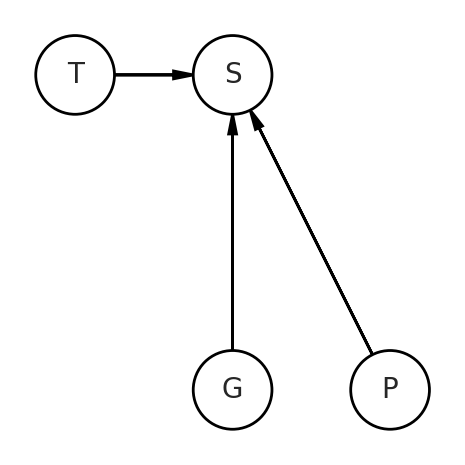

<IPython.core.display.Javascript object>

In [165]:
# model m2d, size and pred (applies to additive or interactive model)


dag = CausalGraphicalModel(
    nodes=["T", "S", "G", "P"],
    edges=[
        ("T", "S"),
        ("G", "S"),
        ("P", "S"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "T": (0, 1),
    "S": (1, 1),
    "G": (1, -1),
    "P": (2, -1)
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [167]:
with pm.Model() as mq2d:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bG = pm.Normal("bG", mu=0, sd=1)
    bP = pm.Normal("bP", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 0.1)
    
    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bG*df_frogs['size_code'] + bP*df_frogs['pred_code']))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq2d = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bP, bG, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bP, bG, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

### Model m2e, size and pred as interactive terms

In [168]:
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code
0,10,no,big,9,0.9,0,1
1,10,no,big,10,1.0,0,1
2,10,no,big,7,0.7,0,1
3,10,no,big,10,1.0,0,1
4,10,no,small,9,0.9,0,0


<IPython.core.display.Javascript object>

In [170]:
pi = df_frogs["pred_code"]
gi = df_frogs["size_code"]

print(len(pi.unique()), len(gi.unique()))

2 2


<IPython.core.display.Javascript object>

In [187]:
with pm.Model() as mq2e:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bGP = pm.Normal("bGP", mu=0, sd=1, shape=(2, 2))
    sigma = pm.Exponential("sigma", 0.1)
    
    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bGP[gi, pi]))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq2e = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bGP, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bGP, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [188]:
az.summary(trace_mq2e)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.067,0.439,0.329,1.733,0.036,0.027,145.0,133.0,148.0,206.0,1.03
"bGP[0,0]",1.399,0.503,0.611,2.215,0.035,0.025,202.0,202.0,203.0,363.0,1.02
"bGP[0,1]",-0.551,0.486,-1.302,0.225,0.037,0.027,177.0,165.0,179.0,250.0,1.02
"bGP[1,0]",1.542,0.495,0.774,2.340,0.035,0.025,204.0,204.0,207.0,297.0,1.02
"bGP[1,1]",-1.413,0.480,-2.178,-0.661,0.036,0.027,178.0,162.0,182.0,257.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
p[43],0.402,0.075,0.285,0.526,0.001,0.001,7204.0,6805.0,7171.0,2828.0,1.00
p[44],0.627,0.073,0.513,0.745,0.001,0.001,6970.0,6908.0,6933.0,2917.0,1.00
p[45],0.393,0.075,0.267,0.509,0.001,0.001,5779.0,5779.0,5790.0,3387.0,1.00
p[46],0.827,0.058,0.739,0.919,0.001,0.001,3205.0,3205.0,3167.0,3173.0,1.00


<IPython.core.display.Javascript object>

### Compare models

Evaluate sigma as a way to understand which models best explain variation.

In [189]:
traces = [trace_mq2a, trace_mq2b, trace_mq2c, trace_mq2d, trace_mq2e]
labels = ["varying effects", "pred", "size", "pred and size (additive)", "pred and size (interactive)"]

<IPython.core.display.Javascript object>

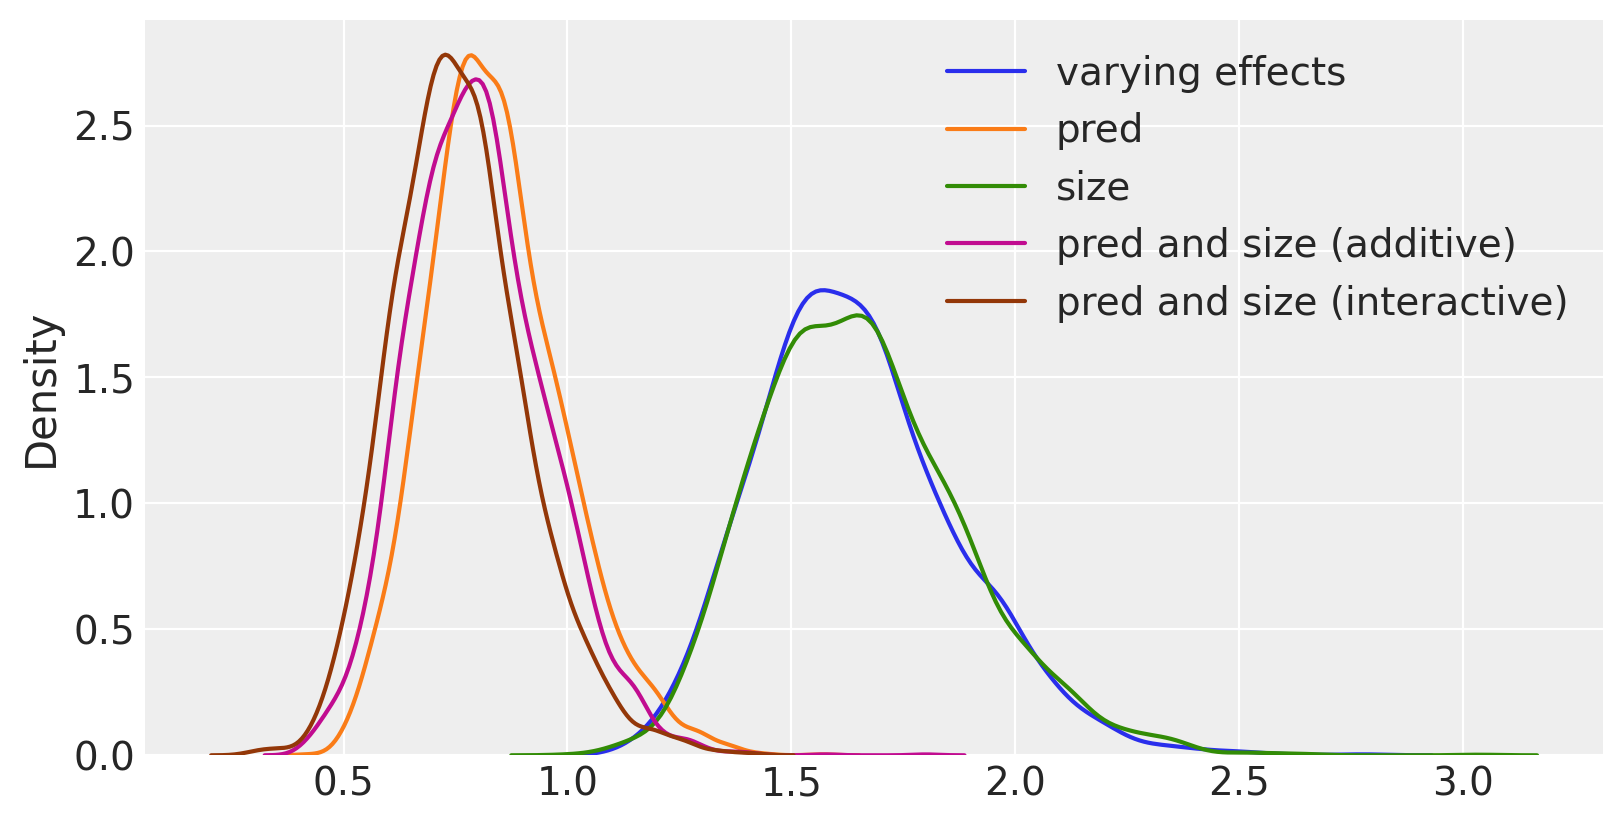

<IPython.core.display.Javascript object>

In [184]:
f, ax1 = plt.subplots(1, 1, figsize=(8, 4))

for i, trace in enumerate(traces):
    trace_df = pm.trace_to_dataframe(trace)
    #az.plot_density(np.array(trace_df['sigma']), ax=ax1, data_labels='x')
    sns.kdeplot(np.array(trace_df['sigma']), ax=ax1, label=labels[i])

ax.set(title='Sigma with different models')
ax1.legend()

This indicates how much the presence of a predator makes on prediction and how little size provides predictive value.

In [185]:
az.compare(
    {"varying effects": trace_mq2a, 
    "pred": trace_mq2b, 
    "size": trace_mq2c,
    "pred and size (add)": trace_mq2d,
    "pred and size (int)": trace_mq2e},
    ic='loo'
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is m

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pred,0,-105.656376,25.419095,0.000000,4.537756e-01,5.207464,0.000000,True,log
pred and size (int),1,-105.874545,25.289153,0.218170,3.971902e-01,5.281461,1.956378,True,log
pred and size (add),2,-105.967291,25.301798,0.310915,5.515249e-16,4.985521,1.321287,True,log
varying effects,3,-109.948618,30.896559,4.292242,1.490342e-01,4.037004,3.747733,True,log
size,4,-111.317916,32.019874,5.661540,0.000000e+00,4.097331,3.740078,True,log


<IPython.core.display.Javascript object>

# Q3

Now estimate the causal effect of `density` on `survival`. Consider whether `pred`
modifies the effect of `density`. There are several good ways to include `density` in
your Binomial GLM. You could treat it as a continuous regression variable (possibly
standardized). Or you could convert it to an ordered category (with three levels).
Compare the σ (tank standard deviation) posterior distribution to σ from your
model in Problem 2. How are they different? Why?

## Answer

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


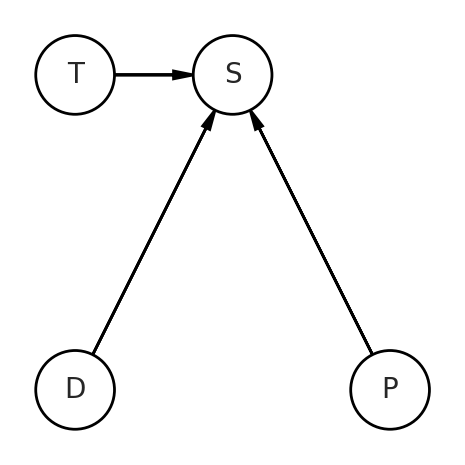

<IPython.core.display.Javascript object>

In [197]:
# model m3a

dag = CausalGraphicalModel(
    nodes=["T", "S", "D", "P"],
    edges=[
        ("T", "S"),
        ("D", "S"),
        ("P", "S"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "T": (0, 1),
    "S": (1, 1),
    "D": (0, -1),
    "P": (2, -1)
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [193]:
df_frogs['density_std'] = standardize(df_frogs['density'])
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code,density_std
0,10,no,big,9,0.9,0,1,-1.297771
1,10,no,big,10,1.0,0,1,-1.297771
2,10,no,big,7,0.7,0,1,-1.297771
3,10,no,big,10,1.0,0,1,-1.297771
4,10,no,small,9,0.9,0,0,-1.297771


<IPython.core.display.Javascript object>

In [200]:
# without predator interaction
with pm.Model() as mq3a:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bD = pm.Normal("bD", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 0.1)
    
    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bD*df_frogs['density_std']))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq3a = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bD, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bD, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [201]:
# with predator interaction
with pm.Model() as mq3b:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bD = pm.Normal("bD", mu=0, sd=1, shape=2)
    sigma = pm.Exponential("sigma", 0.1)
    
    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bD[pi]*df_frogs['density_std']))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq3b = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bD, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bD, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [215]:
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code,density_std
0,10,no,big,9,0.9,0,1,-1.297771
1,10,no,big,10,1.0,0,1,-1.297771
2,10,no,big,7,0.7,0,1,-1.297771
3,10,no,big,10,1.0,0,1,-1.297771
4,10,no,small,9,0.9,0,0,-1.297771


<IPython.core.display.Javascript object>

In [217]:
# with predator interaction
with pm.Model() as mq3c:

    # define priors
    a_bar = pm.Normal("a_bar", mu=0, sd=1)
    bD = pm.Normal("bD", mu=0, sd=1)
    bP = pm.Normal("bP", mu=0, sd=1, shape=2)
    sigma = pm.Exponential("sigma", 0.1)
    
    # adaptive prior
    a_j = pm.Normal("a_j", a_bar, sigma, shape=len(df_frogs))

    # link function
    p = pm.Deterministic("p", pm.math.invlogit(a_j[tank] + bP[df_frogs['pred_code']] + bD*df_frogs['density_std']))

    # likelihood
    s = pm.Binomial("s", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    # fit and get posterior (use return_inferencedata=False to simplify access to posterior)
    trace_mq3c = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_j, sigma, bP, bD, a_bar]
INFO:pymc3:NUTS: [a_j, sigma, bP, bD, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

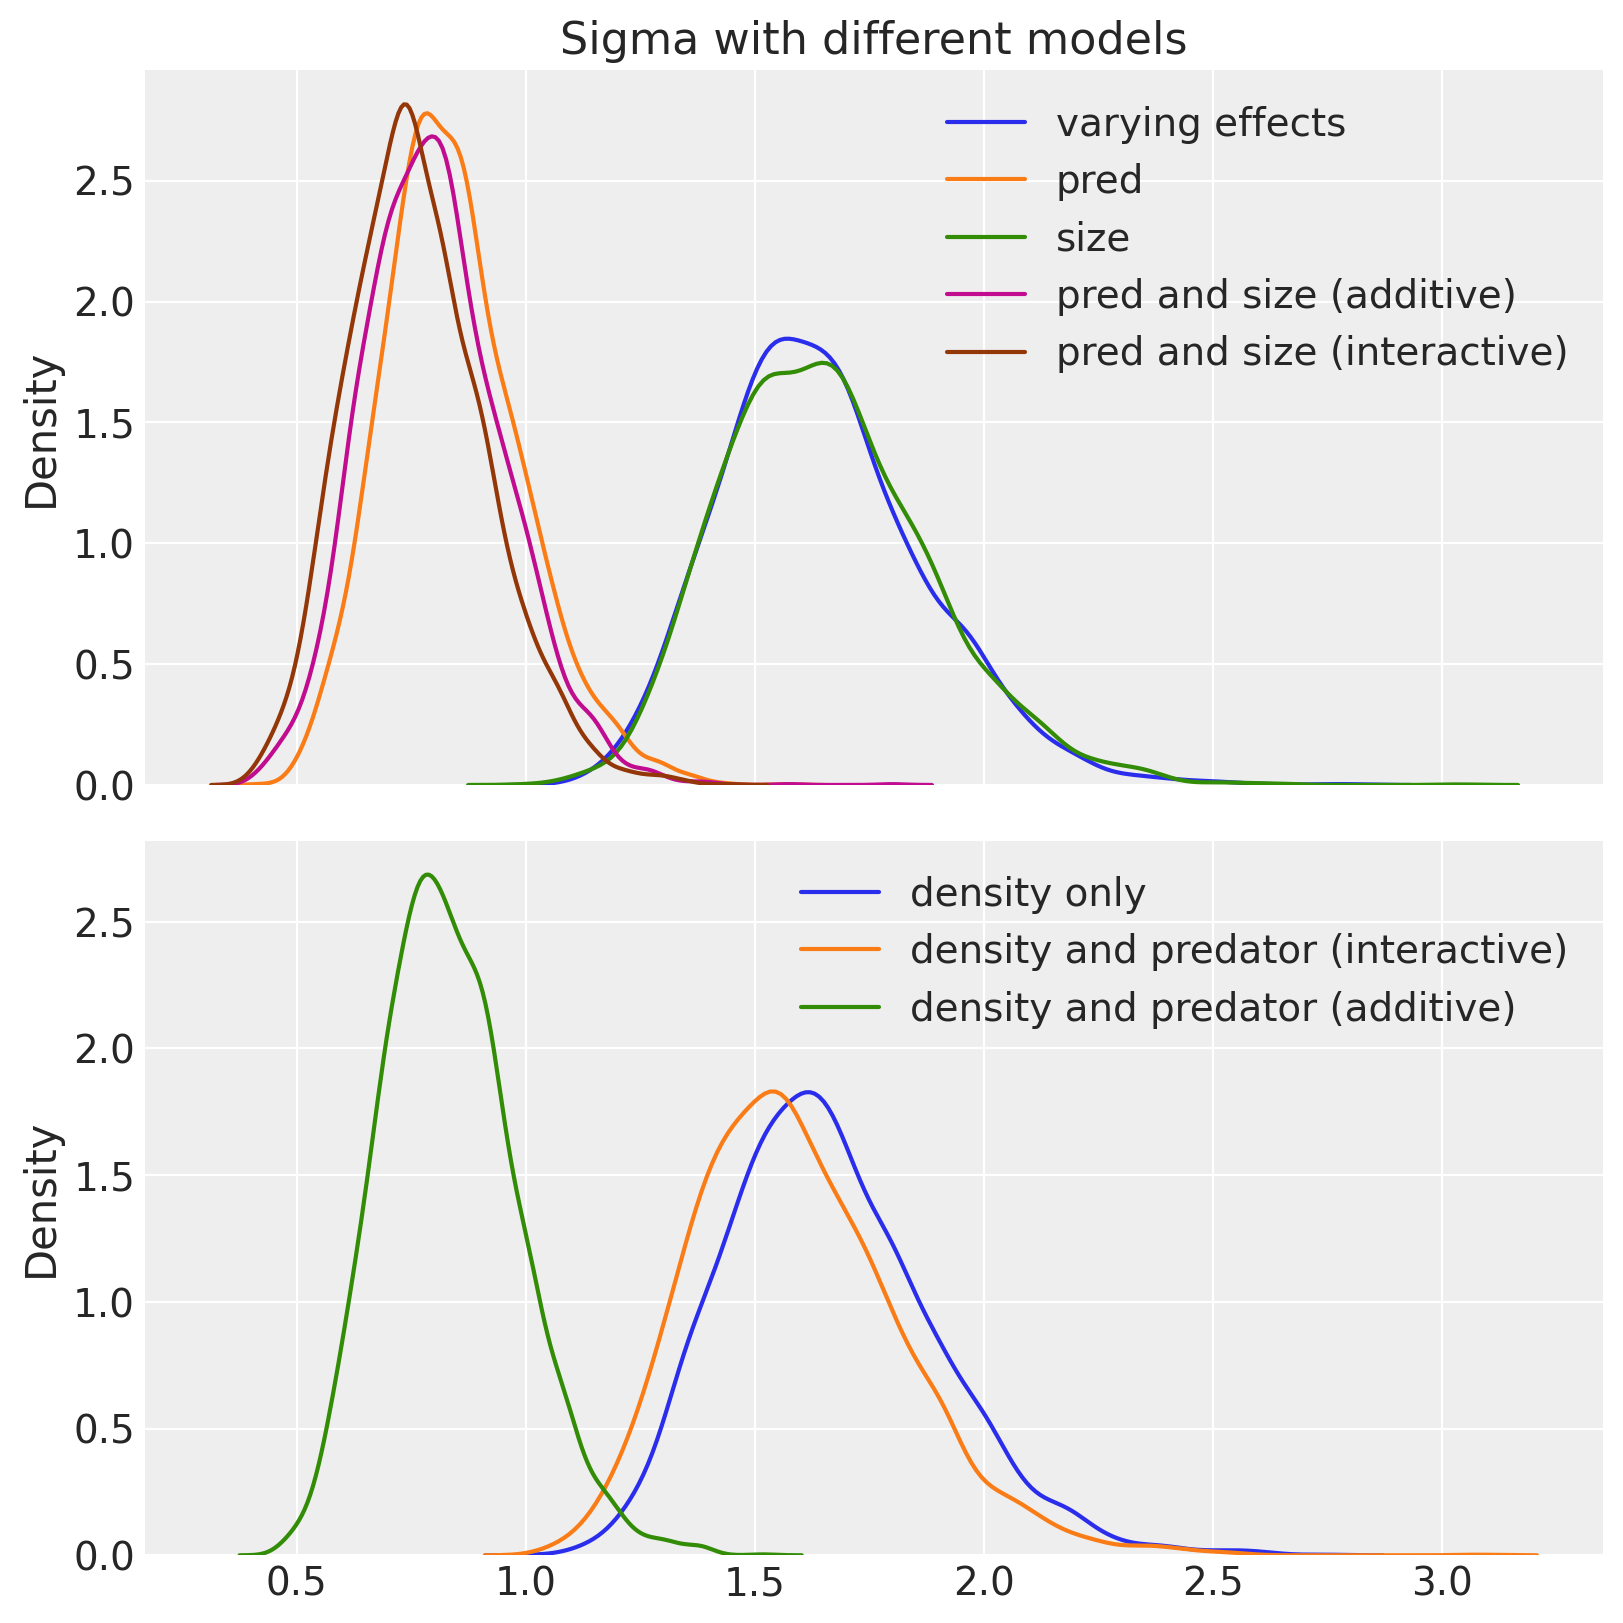

<IPython.core.display.Javascript object>

In [220]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

for i, trace in enumerate(traces):
    trace_df = pm.trace_to_dataframe(trace)
    #az.plot_density(np.array(trace_df['sigma']), ax=ax1, data_labels='x')
    sns.kdeplot(np.array(trace_df['sigma']), ax=ax1, label=labels[i])

ax1.set(title='Sigma with different models')
ax1.legend()


traces2 = [trace_mq3a, trace_mq3b, trace_mq3c]
labels2 = ["density only", "density and predator (interactive)", "density and predator (additive)"]

for i, trace2 in enumerate(traces2):
    trace_df = pm.trace_to_dataframe(trace2)
    sns.kdeplot(np.array(trace_df['sigma']), ax=ax2, label=labels2[i])

ax2.legend()

In [214]:
df_frogs.head(20)

,density,pred,size,surv,propsurv,pred_code,size_code,density_std
0,10,no,big,9,0.90,0,1,-1.297771
1,10,no,big,10,1.00,0,1,-1.297771
2,10,no,big,7,0.70,0,1,-1.297771
3,10,no,big,10,1.00,0,1,-1.297771
4,10,no,small,9,0.90,0,0,-1.297771
5,10,no,small,9,0.90,0,0,-1.297771
6,10,no,small,10,1.00,0,0,-1.297771
7,10,no,small,9,0.90,0,0,-1.297771
8,10,pred,big,4,0.40,1,1,-1.297771
9,10,pred,big,9,0.90,1,1,-1.297771


<IPython.core.display.Javascript object>

# Q4 (optional)

Using your estimates from the previous problems,
compute the expected causal effect of removing predators from a population of tadpoles
with size and density distributed according to this table:

| density | small | large |
| -- | --- | ---- |
| 10 | 25% | 25%  |
| 35 | 25% | 25%  |


In other words, 25% of the population is in groups of 10 small tadpoles, 25% in
groups of 10 large tadpoles, 25% in groups of 35 small tadpoles, and 25% in groups
of 25 large tadpoles. Think carefully about if and how you should incorporate the
tank varying effects in this calculation.

## Answer

yyyyyyy

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>